In [160]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm

In [161]:
# with open('inputs_36.pkl', 'rb') as f, open('targets_36.pkl','rb') as t:
#     inputs = pickle.load(f)
#     targets = pickle.load(t)
# # Shuffle before splitting (preserves alignment of X and y)
# X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# # Train-test split
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_shuffled, y_shuffled, test_size=0.2, random_state=42
# )
# # X_train, X_test, y_train, y_test = train_test_split(
# #     X_train, y_train, test_size=0.2, random_state=42
# # )


In [162]:
# with open("inputs_small_train_36.pkl", "wb") as f:
#     pickle.dump(X_train, f)

# with open("inputs_small_test_36.pkl", "wb") as f:
#     pickle.dump(X_test, f)
# # Save targets
# with open("targets_small_train_36.pkl", "wb") as f:
#     pickle.dump(y_train, f)
# with open("targets_small_test_36.pkl", "wb") as f:
#     pickle.dump(y_test, f)

In [163]:
with open("inputs_small_train_36.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("inputs_small_test_36.pkl", "rb") as f:
    X_test = pickle.load(f)
# Save targets
with open("targets_small_train_36.pkl", "rb") as f:
    Y_train = pickle.load(f)
with open("targets_small_test_36.pkl", "rb") as f:
    Y_test = pickle.load(f)

In [164]:
from sklearn.preprocessing import StandardScaler

# Indexes of features to normalize
norm_idx = [0, 1, 2, 3]  # NDVI, NDBI, Albedo, agg_month (example)

# Flatten X for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_test_flat = X_test.reshape(-1, X_test.shape[2])

# Copy to preserve original
X_train_scaled = X_train_flat.copy()
X_test_scaled = X_test_flat.copy()

# Standard scaler for features
standard_scaler_X = StandardScaler()
X_train_scaled[:, norm_idx] = standard_scaler_X.fit_transform(X_train_flat[:, norm_idx])
X_test_scaled[:, norm_idx] = standard_scaler_X.transform(X_test_flat[:, norm_idx])

# Reshape back to original 3D shape
X_train = X_train_scaled.reshape(X_train.shape)
X_test = X_test_scaled.reshape(X_test.shape)

# --- Target Scaling (y) ---
# Flatten y in case it's 3D or 2D
y_train_flat = Y_train.reshape(-1, 1)
y_test_flat = Y_test.reshape(-1, 1)

standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_test_scaled = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_test = y_test_scaled.reshape(Y_test.shape)


In [165]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [166]:
X_train.shape

(146250, 12, 17)

In [167]:
X_train

array([[[ 0.5553982 ,  0.3003002 , -0.05412168, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.17147514,  0.17628293, -0.01214197, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00790771,  0.07907627,  0.01062005, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.54925615,  0.22211362, -0.06771339, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.18317038,  0.21051365, -0.02944469, ...,  0.        ,
          0.        ,  0.        ],
        [-0.05426793, -0.09131265, -0.00542555, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.40672582,  0.02001441,  0.02671945, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.06840571, -0.19655412,  0.10786658, ...,  0.        ,
          0.        ,  0.        ],
        [-0.05241691, -0.0768665 ,  0.00778759, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.37180838,  0.11907267,  0.00823065, ...,  

In [168]:
Y_train.shape

(146250,)

In [169]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [170]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)  # Output = scalar

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_time_step = lstm_out[:, -1, :]  # take the last time step's output
        out = self.fc(last_time_step)  # (batch_size, 1)
        return out.squeeze(1)  # final shape: (batch_size,)
    


Epoch 1/100 - Train Loss: 0.8364198803901672
Epoch 2/100 - Train Loss: 0.43408364057540894
Epoch 3/100 - Train Loss: 0.8122532963752747
Epoch 4/100 - Train Loss: 0.42163580656051636
Epoch 5/100 - Train Loss: 0.9083312749862671
Epoch 6/100 - Train Loss: 0.9085229635238647
Epoch 7/100 - Train Loss: 0.6012032628059387
Epoch 8/100 - Train Loss: 0.29369983077049255
Epoch 9/100 - Train Loss: 0.1018407791852951
Epoch 10/100 - Train Loss: 0.0597931370139122
Epoch 11/100 - Train Loss: 0.33304789662361145
Epoch 12/100 - Train Loss: 0.31086215376853943
Epoch 13/100 - Train Loss: 0.30814769864082336
Epoch 14/100 - Train Loss: 0.32815396785736084
Epoch 15/100 - Train Loss: 0.40339359641075134
Epoch 16/100 - Train Loss: 0.3491207957267761
Epoch 17/100 - Train Loss: 0.2929457724094391
Epoch 18/100 - Train Loss: 0.06882385164499283
Epoch 19/100 - Train Loss: 0.24271854758262634
Epoch 20/100 - Train Loss: 0.14779804646968842
Epoch 21/100 - Train Loss: 0.26007017493247986
Epoch 22/100 - Train Loss: 0.37

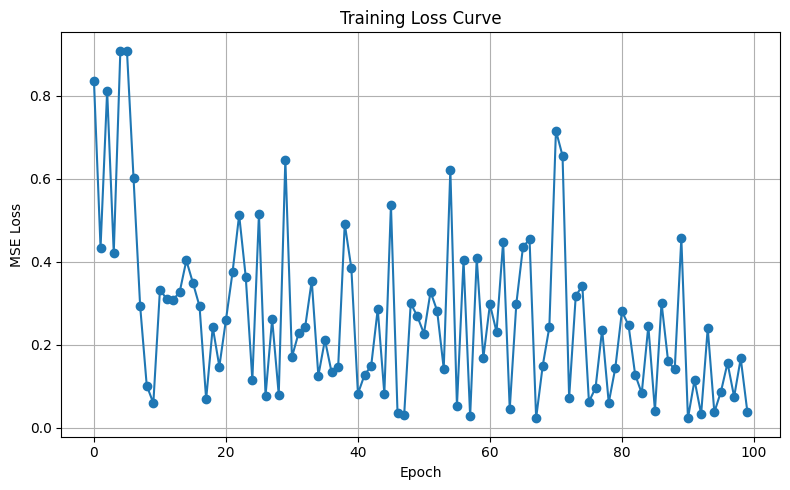

In [171]:
input_size = X_train.shape[2]  # num_features per timestep
model = LSTMPredictor(input_size=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())
plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# If you normalized y, unnormalize here
# y_pred = y_pred * y_std + y_mean
# y_true = y_true * y_std + y_mean

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")


Test MSE:  503.3054
Test RMSE: 22.4345
Test MAE:  7.1682
Test R²:   0.6845
Test MAPE:   0.2255
